In [1]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import pathlib
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from plotnine import *
import seaborn as sn
from tqdm import tqdm
%matplotlib inline

seed = 30
tf.random.set_seed(seed)
gpus = tf.config.list_physical_devices('GPU')

In [2]:
## need this if training on GPU
## tensorflow, get your shit together

if len(gpus)>0:

    from tensorflow.compat.v1 import ConfigProto
    from tensorflow.compat.v1 import InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)

In [3]:
data_path = '/tf/data/dementia/0extra/ADReSS-IS2020-data/train'

filenames = tf.random.shuffle(tf.io.gfile.glob(data_path + '/Full_wave_enhanced_audio/*/*'))

train_cutoff = int(len(filenames)*0.7)
val_cutoff = int(len(filenames)*0.85)

train_files = filenames[:train_cutoff]
val_files = filenames[train_cutoff:val_cutoff]
test_files = filenames[val_cutoff:]

In [4]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                  names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
def get_data_old(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    
    zero_padding = tf.zeros([10000000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    return spectrogram, label

def window(x, size, stride):
    length = int(len(x))
    if length // size == 0:
        zero_padding =  tf.zeros([size] - tf.shape(x), dtype=tf.float32)
        x = tf.cast(x, tf.float32)
        x = tf.concat([x, zero_padding], 0)
        length = int(len(x))
    return tf.map_fn(lambda i: x[i*stride:i*stride+size], tf.range((length-size)//stride+1), dtype=tf.float32)

def get_data(file_path):

    names = meta.ID
    name = tf.strings.split(tf.strings.split(file_path, os.path.sep)[-1], '.')[0] + ' '
    label = tf.gather(meta.MMSE, tf.where(tf.equal(names, name))[0][0])
    
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
#     waveform = decode_audio(audio_binary)
        
    rolling_waveform_tensors = window(waveform, size=_*size_sec, stride=_*stride_sec)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
        
    return rolling_spectrograms, label

In [7]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_data, num_parallel_calls=AUTOTUNE)\
                        .cache()\
                        .prefetch(100)\
                        .flat_map(lambda x,y: tf.data.Dataset.zip((
                                    tf.data.Dataset.from_tensor_slices(x), 
                                    tf.data.Dataset.from_tensor_slices([y])
                        )))\
                        .shuffle(100)
    return output_ds

In [8]:
size_sec = 30
stride_sec = 1

In [9]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Instructions for updating:
Use fn_output_signature instead


In [10]:
for spectrogram, y in train_ds.take(1):
    input_shape = spectrogram.shape
    print(input_shape)
    print(y)


(30, 257, 1)
tf.Tensor(23, shape=(), dtype=int64)


In [11]:
batch_size = 128
train_ds_b = train_ds.batch(batch_size)
val_ds_b = val_ds.batch(batch_size)

In [12]:
print('Input shape:', input_shape)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Reshape((input_shape[0],input_shape[1])),
    norm_layer,
    
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.LSTM(128, activation='relu', kernel_initializer='he_normal', return_sequences=True),
    layers.Dropout(0.25),
    layers.LSTM(64, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.25),
    layers.Dense(1)
])

model.summary()

Input shape: (30, 257, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 257)           0         
_________________________________________________________________
normalization (Normalization (None, 30, 257)           3         
_________________________________________________________________
dense (Dense)                (None, 30, 256)           66048     
_________________________________________________________________
dropout (Dropout)            (None, 30, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 30, 128)           197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='mse',
    metrics='mse'
)

In [14]:
EPOCHS = 10000
history = model.fit(
    train_ds_b, 
    validation_data=val_ds_b,  
    epochs=EPOCHS,
    callbacks=[callback]
)

Epoch 1/10000
1/1 [==============================] - 3s 3s/step - loss: 1806.5590 - mse: 1806.5590 - val_loss: 1831.3893 - val_mse: 1831.3893
Epoch 2/10000
1/1 [==============================] - 0s 143ms/step - loss: 977.9045 - mse: 977.9045 - val_loss: 5272.5054 - val_mse: 5272.5054
Epoch 3/10000
1/1 [==============================] - 0s 143ms/step - loss: 603.3000 - mse: 603.3000 - val_loss: 805.1472 - val_mse: 805.1472
Epoch 4/10000
1/1 [==============================] - 0s 141ms/step - loss: 677.1946 - mse: 677.1946 - val_loss: 839.1245 - val_mse: 839.1245
Epoch 5/10000
1/1 [==============================] - 0s 141ms/step - loss: 605.1604 - mse: 605.1604 - val_loss: 747.4308 - val_mse: 747.4308
Epoch 6/10000
1/1 [==============================] - 0s 144ms/step - loss: 593.2695 - mse: 593.2695 - val_loss: 754.1369 - val_mse: 754.1369
Epoch 7/10000
1/1 [==============================] - 0s 143ms/step - loss: 570.6824 - mse: 570.6824 - val_loss: 882.0496 - val_mse: 882.0496
Epoch 8/10

Epoch 117/10000
1/1 [==============================] - 0s 143ms/step - loss: 73.5838 - mse: 73.5838 - val_loss: 51.9054 - val_mse: 51.9054
Epoch 118/10000
1/1 [==============================] - 0s 145ms/step - loss: 69.5926 - mse: 69.5926 - val_loss: 54.7958 - val_mse: 54.7958
Epoch 119/10000
1/1 [==============================] - 0s 144ms/step - loss: 75.9070 - mse: 75.9070 - val_loss: 60.8076 - val_mse: 60.8076
Epoch 120/10000
1/1 [==============================] - 0s 142ms/step - loss: 73.0712 - mse: 73.0712 - val_loss: 57.6791 - val_mse: 57.6791
Epoch 121/10000
1/1 [==============================] - 0s 145ms/step - loss: 49.2337 - mse: 49.2337 - val_loss: 47.3005 - val_mse: 47.3005
Epoch 122/10000
1/1 [==============================] - 0s 142ms/step - loss: 75.4140 - mse: 75.4140 - val_loss: 44.4607 - val_mse: 44.4607
Epoch 123/10000
1/1 [==============================] - 0s 139ms/step - loss: 48.5725 - mse: 48.5725 - val_loss: 48.1692 - val_mse: 48.1692
Epoch 124/10000
1/1 [======

Epoch 176/10000
1/1 [==============================] - 0s 148ms/step - loss: 52.3679 - mse: 52.3679 - val_loss: 36.7406 - val_mse: 36.7406
Epoch 177/10000
1/1 [==============================] - 0s 157ms/step - loss: 49.9984 - mse: 49.9984 - val_loss: 44.4797 - val_mse: 44.4797
Epoch 178/10000
1/1 [==============================] - 0s 150ms/step - loss: 55.6345 - mse: 55.6345 - val_loss: 43.2255 - val_mse: 43.2255
Epoch 179/10000
1/1 [==============================] - 0s 153ms/step - loss: 49.0404 - mse: 49.0404 - val_loss: 40.9546 - val_mse: 40.9546
Epoch 180/10000
1/1 [==============================] - 0s 152ms/step - loss: 58.6934 - mse: 58.6934 - val_loss: 37.0942 - val_mse: 37.0942
Epoch 181/10000
1/1 [==============================] - 0s 149ms/step - loss: 53.0753 - mse: 53.0753 - val_loss: 31.0710 - val_mse: 31.0710
Epoch 182/10000
1/1 [==============================] - 0s 148ms/step - loss: 47.0900 - mse: 47.0900 - val_loss: 30.5392 - val_mse: 30.5392
Epoch 183/10000
1/1 [======

Epoch 235/10000
1/1 [==============================] - 0s 146ms/step - loss: 50.7191 - mse: 50.7191 - val_loss: 40.4092 - val_mse: 40.4092
Epoch 236/10000
1/1 [==============================] - 0s 147ms/step - loss: 47.0159 - mse: 47.0159 - val_loss: 40.8081 - val_mse: 40.8081
Epoch 237/10000
1/1 [==============================] - 0s 145ms/step - loss: 41.4106 - mse: 41.4106 - val_loss: 52.2223 - val_mse: 52.2223
Epoch 238/10000
1/1 [==============================] - 0s 264ms/step - loss: 37.9805 - mse: 37.9805 - val_loss: 53.8499 - val_mse: 53.8499
Epoch 239/10000
1/1 [==============================] - 0s 144ms/step - loss: 40.5069 - mse: 40.5069 - val_loss: 42.4933 - val_mse: 42.4933
Epoch 240/10000
1/1 [==============================] - 0s 149ms/step - loss: 45.2617 - mse: 45.2617 - val_loss: 35.8195 - val_mse: 35.8195
Epoch 241/10000
1/1 [==============================] - 0s 144ms/step - loss: 57.7892 - mse: 57.7892 - val_loss: 36.4547 - val_mse: 36.4547
Epoch 242/10000
1/1 [======

Epoch 294/10000
1/1 [==============================] - 0s 146ms/step - loss: 45.3321 - mse: 45.3321 - val_loss: 41.5195 - val_mse: 41.5195
Epoch 295/10000
1/1 [==============================] - 0s 142ms/step - loss: 19.8541 - mse: 19.8541 - val_loss: 51.4223 - val_mse: 51.4223
Epoch 296/10000
1/1 [==============================] - 0s 137ms/step - loss: 31.1072 - mse: 31.1072 - val_loss: 48.8027 - val_mse: 48.8027
Epoch 297/10000
1/1 [==============================] - 0s 138ms/step - loss: 31.1729 - mse: 31.1729 - val_loss: 44.0006 - val_mse: 44.0006
Epoch 298/10000
1/1 [==============================] - 0s 142ms/step - loss: 34.0155 - mse: 34.0155 - val_loss: 45.3924 - val_mse: 45.3924
Epoch 299/10000
1/1 [==============================] - 0s 141ms/step - loss: 36.7684 - mse: 36.7684 - val_loss: 52.8625 - val_mse: 52.8625
Epoch 300/10000
1/1 [==============================] - 0s 142ms/step - loss: 30.7253 - mse: 30.7253 - val_loss: 52.3921 - val_mse: 52.3921
Epoch 301/10000
1/1 [======

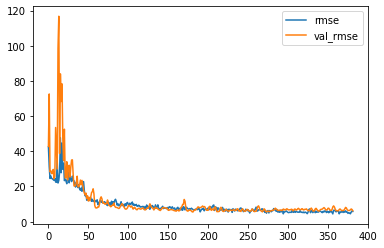

In [15]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mse']), np.sqrt(metrics['val_mse']))
plt.legend(['rmse', 'val_rmse'])
plt.show()

In [16]:
np.sqrt(model.evaluate(val_ds.batch(batch_size)))

1/1 [==============================] - 0s 83ms/step - loss: 38.7590 - mse: 38.7590


array([6.22567593, 6.22567593])

In [17]:
np.sqrt(model.evaluate(test_ds.batch(batch_size)))

1/1 [==============================] - 1s 702ms/step - loss: 70.5698 - mse: 70.5698


array([8.40058112, 8.40058112])

In [31]:
train_files[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'/tf/data/dementia/0extra/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S012.wav'>

In [32]:
model.predict(preprocess_dataset([train_files[0]]).batch(30), verbose=2)

1/1 - 0s


array([[27.613955]], dtype=float32)

In [33]:
model.predict(get_data(train_files[0])[0])

array([[27.613953],
       [27.926525],
       [28.089151],
       [27.852127],
       [27.772894],
       [27.663982],
       [26.987913],
       [26.662405],
       [26.406897],
       [26.453966],
       [27.014967],
       [27.170177],
       [26.678186],
       [25.764532],
       [25.767687]], dtype=float32)

In [36]:
model.predict(get_data(train_files[0])[0]).mean()

27.055023

In [35]:
get_data(train_files[0])[1]

<tf.Tensor: shape=(), dtype=int64, numpy=29>

In [21]:
meta = meta.assign(split = '', predict = -99.99, predict_group = 'cc')
for file in train_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'train'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in test_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'test'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'
for file in val_files:
    ID = file.numpy().decode('utf-8').split('/')[-1].split('.')[0]
    predict = model.predict(get_data(file)[0]).mean()
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict'] = max(1, min(predict, 30))
    meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'split'] = 'val'
    if (predict < 24):
        meta.at[np.where(meta.ID == (ID + ' '))[0][0], 'predict_group'] = 'cd'

In [22]:
meta.predict.describe()

count    108.000000
mean      22.461428
std        4.750969
min        7.978041
25%       19.454902
50%       23.823333
75%       26.175219
max       29.372707
Name: predict, dtype: float64

In [39]:
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
def cal_rmse(g):
    rmse = np.sqrt(mean_squared_error(g['MMSE'], g['predict'] ) )
    return pd.Series(dict(rmse = rmse ))

meta.groupby('split').apply(cal_rmse).reset_index()

,split,rmse
0,test,6.896728
1,train,5.046426
2,val,7.598230


In [24]:
meta.groupby('Gender').apply(cal_rmse).reset_index()

,Gender,rmse
0,female,5.670140
1,male,5.974397


In [25]:
np.sqrt(mean_squared_error(meta['MMSE'], meta['predict'] ))

5.8073335540360045

In [38]:
meta.MMSE.describe()

count    108.000000
mean      23.092593
std        7.215685
min        1.000000
25%       17.000000
50%       27.000000
75%       29.000000
max       30.000000
Name: MMSE, dtype: float64

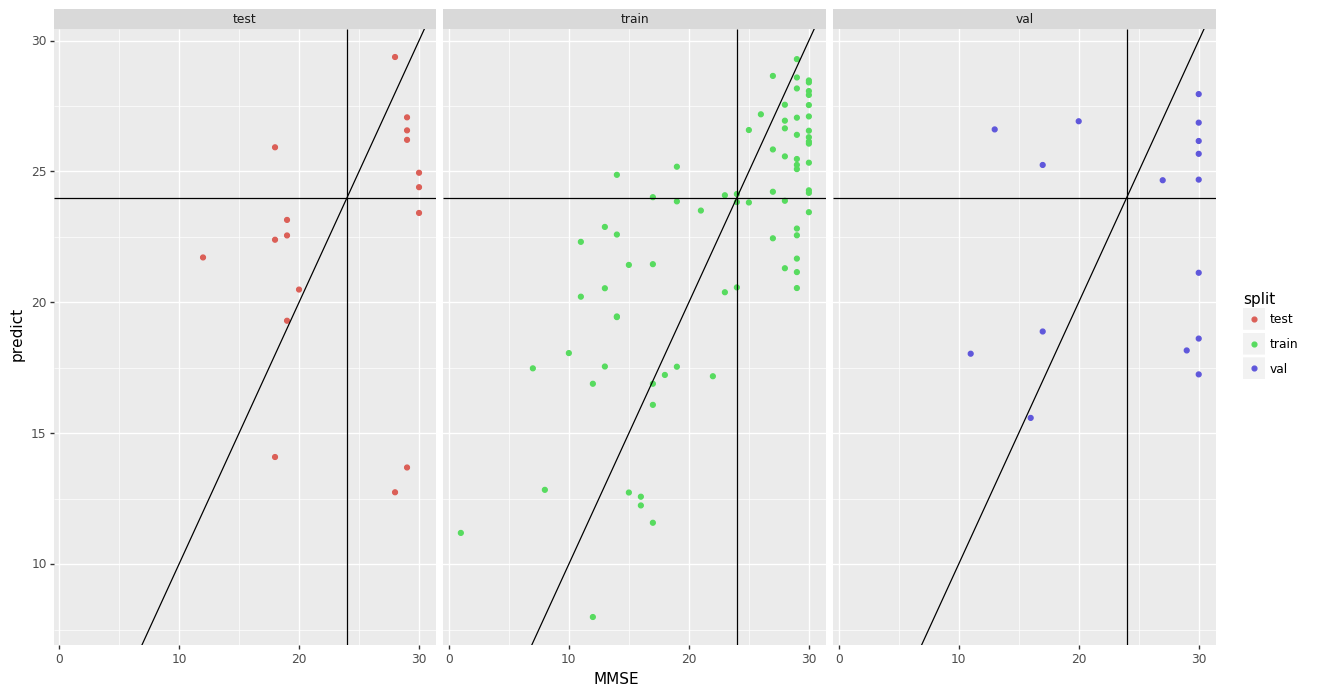

<ggplot: (-9223363255831778153)>

In [26]:
ggplot(meta) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'split')) + \
facet_wrap('split', nrow = 1) + \
geom_abline(aes(intercept = 0, slope = 1, lty = 2)) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 24, lty = 2)) + \
theme(figure_size = (15, 8))

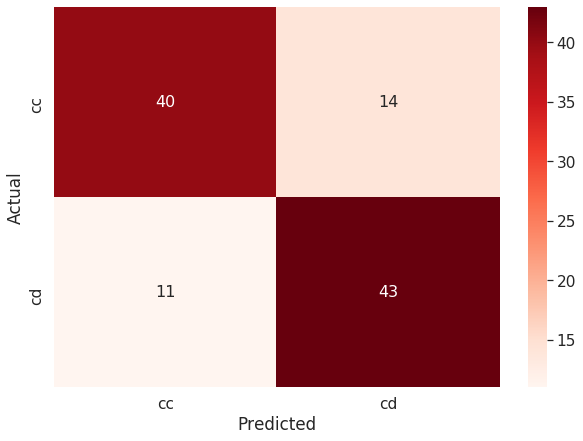

In [27]:
y_true = meta.Group
y_pred = meta.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [45]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          cc       0.78      0.74      0.76        54
          cd       0.75      0.80      0.77        54

    accuracy                           0.77       108
   macro avg       0.77      0.77      0.77       108
weighted avg       0.77      0.77      0.77       108



In [30]:
# model.save('saved_model/base_line/20210222')

INFO:tensorflow:Assets written to: saved_model/base_line/20210222/assets


In [29]:
ls saved_model/base_line

20210210/  20210217/  20210222/


# Pitts Corpus

In [77]:
data_path_pitt = '/tf/data/dementia/English/Pitt/'
files_pitt = tf.io.gfile.glob(data_path_pitt + 'Control/cookie/*.mp3') + \
             tf.io.gfile.glob(data_path_pitt + 'Dementia/cookie/*.mp3')

In [173]:
def model_inference(filepath):

    import tensorflow as tf
    import numpy as np
    import json
    import requests	
    import os
    from datetime import datetime
    
    input_file = filepath
    if not filepath.lower().endswith(".wav"):
        tmp_name = "tmp-"+datetime.now().strftime("%Y%m%d-%H%M%S")
        input_file = os.path.dirname(filepath)+"/"+tmp_name+".wav"
        cmd = "ffmpeg -i " + filepath + " " + input_file
        os.system(cmd)
    
    audio_binary = tf.io.read_file(input_file)
    audio, _ = tf.audio.decode_wav(audio_binary)
    if audio.shape[1] > 1:
        audio = tf.reshape(audio[:, 0], (audio.shape[0],1))

    waveform = tf.squeeze(audio, axis=-1)    
    rolling_waveform_tensors = window(waveform, size=_*30, stride=_*1)
    rolling_spectrograms = tf.signal.stft(rolling_waveform_tensors, frame_length=512, frame_step=_)
    rolling_spectrograms = tf.abs(rolling_spectrograms)
    rolling_spectrograms = tf.expand_dims(rolling_spectrograms, -1)
    rolling_spectrograms = rolling_spectrograms.numpy().tolist()
    
    predictions = model.predict(rolling_spectrograms)
    results = [x[0] for x in predictions]
    result = sum(results)/len(results)

    os.system('rm ' + input_file)
    return result, results

In [179]:
meta_pitt = pd.DataFrame(columns= ['file', 'ID', 'Group', 'MMSE', 'predict', 'predict_group', 'predicts'])
for file in tqdm(files_pitt):
    print(file)
    ID = file.split('/')[-1].split('.')[0]
    Group = file.split('/')[6]
    cha = pd.read_fwf(data_path_pitt + 'Pitt/' + Group + '/cookie/' + ID + '.cha')  
    cha_id = [x for x in cha['@UTF8'] if str.startswith(x, '@ID:')][0]
    
    if (cha_id.split('|')[-3] == ''):
        MMSE = np.NaN
    else:
        MMSE = int(cha_id.split('|')[-3])
        
    predict, predicts = model_inference(file)
    if (predict < 24):
        predict_group = 'Dementia'
    else:
        predict_group = 'Control'
    meta_pitt = meta_pitt.append(pd.DataFrame([[file, ID, Group, MMSE, predict, predict_group, predicts]], 
                                  columns = list(meta_pitt.columns)))




  0%|          | 0/552 [00:00<?, ?it/s]

/tf/data/dementia/English/Pitt/Control/cookie/128-3.mp3





  0%|          | 1/552 [00:06<58:18,  6.35s/it]

/tf/data/dementia/English/Pitt/Control/cookie/229-2.mp3





  0%|          | 2/552 [00:07<42:34,  4.64s/it]

/tf/data/dementia/English/Pitt/Control/cookie/196-0.mp3





  1%|          | 3/552 [00:08<34:19,  3.75s/it]

/tf/data/dementia/English/Pitt/Control/cookie/073-3.mp3





  1%|          | 4/552 [00:11<31:22,  3.44s/it]

/tf/data/dementia/English/Pitt/Control/cookie/668-0.mp3





  1%|          | 5/552 [00:13<26:25,  2.90s/it]

/tf/data/dementia/English/Pitt/Control/cookie/118-2.mp3





  1%|          | 6/552 [00:14<21:51,  2.40s/it]

/tf/data/dementia/English/Pitt/Control/cookie/086-2.mp3





  1%|▏         | 7/552 [00:15<17:48,  1.96s/it]

/tf/data/dementia/English/Pitt/Control/cookie/073-1.mp3





  1%|▏         | 8/552 [00:17<18:38,  2.06s/it]

/tf/data/dementia/English/Pitt/Control/cookie/296-2.mp3





  2%|▏         | 9/552 [00:20<21:14,  2.35s/it]

/tf/data/dementia/English/Pitt/Control/cookie/121-0.mp3





  2%|▏         | 10/552 [00:26<29:51,  3.31s/it]

/tf/data/dementia/English/Pitt/Control/cookie/167-2.mp3





  2%|▏         | 11/552 [00:27<23:35,  2.62s/it]

/tf/data/dementia/English/Pitt/Control/cookie/021-4.mp3





  2%|▏         | 12/552 [00:27<17:21,  1.93s/it]

/tf/data/dementia/English/Pitt/Control/cookie/002-1.mp3





  2%|▏         | 13/552 [00:29<18:47,  2.09s/it]

/tf/data/dementia/English/Pitt/Control/cookie/137-2.mp3





  3%|▎         | 14/552 [00:30<15:18,  1.71s/it]

/tf/data/dementia/English/Pitt/Control/cookie/302-0.mp3





  3%|▎         | 15/552 [00:31<13:56,  1.56s/it]

/tf/data/dementia/English/Pitt/Control/cookie/137-1.mp3





  3%|▎         | 16/552 [00:33<13:02,  1.46s/it]

/tf/data/dementia/English/Pitt/Control/cookie/141-0.mp3





  3%|▎         | 17/552 [00:33<11:11,  1.26s/it]

/tf/data/dementia/English/Pitt/Control/cookie/141-1.mp3





  3%|▎         | 18/552 [00:34<10:36,  1.19s/it]

/tf/data/dementia/English/Pitt/Control/cookie/266-0.mp3





  3%|▎         | 19/552 [00:35<09:17,  1.05s/it]

/tf/data/dementia/English/Pitt/Control/cookie/182-3.mp3





  4%|▎         | 20/552 [00:36<09:40,  1.09s/it]

/tf/data/dementia/English/Pitt/Control/cookie/021-2.mp3





  4%|▍         | 21/552 [00:37<08:01,  1.10it/s]

/tf/data/dementia/English/Pitt/Control/cookie/068-3.mp3





  4%|▍         | 22/552 [00:38<09:58,  1.13s/it]

/tf/data/dementia/English/Pitt/Control/cookie/155-0.mp3





  4%|▍         | 23/552 [00:41<12:32,  1.42s/it]

/tf/data/dementia/English/Pitt/Control/cookie/045-0.mp3





  4%|▍         | 24/552 [00:44<18:17,  2.08s/it]

/tf/data/dementia/English/Pitt/Control/cookie/052-0.mp3





  5%|▍         | 25/552 [00:46<16:30,  1.88s/it]

/tf/data/dementia/English/Pitt/Control/cookie/172-0.mp3





  5%|▍         | 26/552 [00:48<17:23,  1.98s/it]

/tf/data/dementia/English/Pitt/Control/cookie/166-1.mp3





  5%|▍         | 27/552 [00:51<21:10,  2.42s/it]

/tf/data/dementia/English/Pitt/Control/cookie/068-2.mp3





  5%|▌         | 28/552 [00:53<18:24,  2.11s/it]

/tf/data/dementia/English/Pitt/Control/cookie/146-1.mp3





  5%|▌         | 29/552 [00:54<16:45,  1.92s/it]

/tf/data/dementia/English/Pitt/Control/cookie/242-0.mp3





  5%|▌         | 30/552 [00:56<17:09,  1.97s/it]

/tf/data/dementia/English/Pitt/Control/cookie/691-0.mp3





  6%|▌         | 31/552 [00:58<17:18,  1.99s/it]

/tf/data/dementia/English/Pitt/Control/cookie/006-4.mp3





  6%|▌         | 32/552 [01:01<19:34,  2.26s/it]

/tf/data/dementia/English/Pitt/Control/cookie/211-1.mp3





  6%|▌         | 33/552 [01:04<20:52,  2.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/267-2.mp3





  6%|▌         | 34/552 [01:05<18:32,  2.15s/it]

/tf/data/dementia/English/Pitt/Control/cookie/113-1.mp3





  6%|▋         | 35/552 [01:07<16:36,  1.93s/it]

/tf/data/dementia/English/Pitt/Control/cookie/034-1.mp3





  7%|▋         | 36/552 [01:09<16:17,  1.89s/it]

/tf/data/dementia/English/Pitt/Control/cookie/155-3.mp3





  7%|▋         | 37/552 [01:10<14:14,  1.66s/it]

/tf/data/dementia/English/Pitt/Control/cookie/015-2.mp3





  7%|▋         | 38/552 [01:13<18:56,  2.21s/it]

/tf/data/dementia/English/Pitt/Control/cookie/096-1.mp3





  7%|▋         | 39/552 [01:16<18:58,  2.22s/it]

/tf/data/dementia/English/Pitt/Control/cookie/266-2.mp3





  7%|▋         | 40/552 [01:18<19:34,  2.29s/it]

/tf/data/dementia/English/Pitt/Control/cookie/056-4.mp3





  7%|▋         | 41/552 [01:19<16:08,  1.90s/it]

/tf/data/dementia/English/Pitt/Control/cookie/015-3.mp3





  8%|▊         | 42/552 [01:21<16:50,  1.98s/it]

/tf/data/dementia/English/Pitt/Control/cookie/304-2.mp3





  8%|▊         | 43/552 [01:22<14:42,  1.73s/it]

/tf/data/dementia/English/Pitt/Control/cookie/124-1.mp3





  8%|▊         | 44/552 [01:27<23:03,  2.72s/it]

/tf/data/dementia/English/Pitt/Control/cookie/209-1.mp3





  8%|▊         | 45/552 [01:28<17:40,  2.09s/it]

/tf/data/dementia/English/Pitt/Control/cookie/045-2.mp3





  8%|▊         | 46/552 [01:32<21:36,  2.56s/it]

/tf/data/dementia/English/Pitt/Control/cookie/296-0.mp3





  9%|▊         | 47/552 [01:33<19:38,  2.33s/it]

/tf/data/dementia/English/Pitt/Control/cookie/021-1.mp3





  9%|▊         | 48/552 [01:36<20:17,  2.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/209-2.mp3





  9%|▉         | 49/552 [01:37<17:53,  2.13s/it]

/tf/data/dementia/English/Pitt/Control/cookie/208-1.mp3





  9%|▉         | 50/552 [01:38<14:27,  1.73s/it]

/tf/data/dementia/English/Pitt/Control/cookie/121-3.mp3





  9%|▉         | 51/552 [01:41<16:43,  2.00s/it]

/tf/data/dementia/English/Pitt/Control/cookie/107-1.mp3





  9%|▉         | 52/552 [01:42<15:08,  1.82s/it]

/tf/data/dementia/English/Pitt/Control/cookie/130-3.mp3





 10%|▉         | 53/552 [01:43<11:40,  1.40s/it]

/tf/data/dementia/English/Pitt/Control/cookie/318-2.mp3





 10%|▉         | 54/552 [01:43<09:04,  1.09s/it]

/tf/data/dementia/English/Pitt/Control/cookie/227-0.mp3





 10%|▉         | 55/552 [01:45<10:16,  1.24s/it]

/tf/data/dementia/English/Pitt/Control/cookie/340-0.mp3





 10%|█         | 56/552 [01:46<10:29,  1.27s/it]

/tf/data/dementia/English/Pitt/Control/cookie/114-0.mp3





 10%|█         | 57/552 [01:47<09:32,  1.16s/it]

/tf/data/dementia/English/Pitt/Control/cookie/175-0.mp3





 11%|█         | 58/552 [01:49<11:44,  1.43s/it]

/tf/data/dementia/English/Pitt/Control/cookie/141-3.mp3





 11%|█         | 59/552 [01:50<11:31,  1.40s/it]

/tf/data/dementia/English/Pitt/Control/cookie/071-1.mp3





 11%|█         | 60/552 [01:51<09:14,  1.13s/it]

/tf/data/dementia/English/Pitt/Control/cookie/006-2.mp3





 11%|█         | 61/552 [01:52<08:27,  1.03s/it]

/tf/data/dementia/English/Pitt/Control/cookie/093-0.mp3





 11%|█         | 62/552 [01:53<08:38,  1.06s/it]

/tf/data/dementia/English/Pitt/Control/cookie/105-1.mp3





 11%|█▏        | 63/552 [01:54<09:31,  1.17s/it]

/tf/data/dementia/English/Pitt/Control/cookie/118-4.mp3





 12%|█▏        | 64/552 [01:56<10:43,  1.32s/it]

/tf/data/dementia/English/Pitt/Control/cookie/114-3.mp3





 12%|█▏        | 65/552 [01:57<10:29,  1.29s/it]

/tf/data/dementia/English/Pitt/Control/cookie/015-1.mp3





 12%|█▏        | 66/552 [02:00<15:09,  1.87s/it]

/tf/data/dementia/English/Pitt/Control/cookie/145-3.mp3





 12%|█▏        | 67/552 [02:03<16:31,  2.04s/it]

/tf/data/dementia/English/Pitt/Control/cookie/006-3.mp3





 12%|█▏        | 68/552 [02:05<16:09,  2.00s/it]

/tf/data/dementia/English/Pitt/Control/cookie/086-4.mp3





 12%|█▎        | 69/552 [02:07<17:35,  2.18s/it]

/tf/data/dementia/English/Pitt/Control/cookie/130-2.mp3





 13%|█▎        | 70/552 [02:08<13:03,  1.62s/it]

/tf/data/dementia/English/Pitt/Control/cookie/166-2.mp3





 13%|█▎        | 71/552 [02:09<12:37,  1.57s/it]

/tf/data/dementia/English/Pitt/Control/cookie/684-0.mp3





 13%|█▎        | 72/552 [02:12<16:55,  2.12s/it]

/tf/data/dementia/English/Pitt/Control/cookie/096-2.mp3





 13%|█▎        | 73/552 [02:14<15:14,  1.91s/it]

/tf/data/dementia/English/Pitt/Control/cookie/142-0.mp3





 13%|█▎        | 74/552 [02:16<15:45,  1.98s/it]

/tf/data/dementia/English/Pitt/Control/cookie/118-0.mp3





 14%|█▎        | 75/552 [02:17<12:47,  1.61s/it]

/tf/data/dementia/English/Pitt/Control/cookie/013-0.mp3





 14%|█▍        | 76/552 [02:18<12:38,  1.59s/it]

/tf/data/dementia/English/Pitt/Control/cookie/242-2.mp3





 14%|█▍        | 77/552 [02:21<16:24,  2.07s/it]

/tf/data/dementia/English/Pitt/Control/cookie/255-0.mp3





 14%|█▍        | 78/552 [02:23<14:12,  1.80s/it]

/tf/data/dementia/English/Pitt/Control/cookie/034-2.mp3





 14%|█▍        | 79/552 [02:24<14:00,  1.78s/it]

/tf/data/dementia/English/Pitt/Control/cookie/175-2.mp3





 14%|█▍        | 80/552 [02:26<13:29,  1.71s/it]

/tf/data/dementia/English/Pitt/Control/cookie/068-0.mp3





 15%|█▍        | 81/552 [02:28<14:23,  1.83s/it]

/tf/data/dementia/English/Pitt/Control/cookie/142-1.mp3





 15%|█▍        | 82/552 [02:29<13:07,  1.68s/it]

/tf/data/dementia/English/Pitt/Control/cookie/105-0.mp3





 15%|█▌        | 83/552 [02:31<14:07,  1.81s/it]

/tf/data/dementia/English/Pitt/Control/cookie/013-2.mp3





 15%|█▌        | 84/552 [02:33<13:06,  1.68s/it]

/tf/data/dementia/English/Pitt/Control/cookie/015-0.mp3





 15%|█▌        | 85/552 [02:37<18:55,  2.43s/it]

/tf/data/dementia/English/Pitt/Control/cookie/132-0.mp3





 16%|█▌        | 86/552 [02:39<16:47,  2.16s/it]

/tf/data/dementia/English/Pitt/Control/cookie/274-0.mp3





 16%|█▌        | 87/552 [02:40<15:07,  1.95s/it]

/tf/data/dementia/English/Pitt/Control/cookie/248-2.mp3





 16%|█▌        | 88/552 [02:41<12:12,  1.58s/it]

/tf/data/dementia/English/Pitt/Control/cookie/128-2.mp3





 16%|█▌        | 89/552 [02:46<19:54,  2.58s/it]

/tf/data/dementia/English/Pitt/Control/cookie/686-0.mp3





 16%|█▋        | 90/552 [02:48<18:50,  2.45s/it]

/tf/data/dementia/English/Pitt/Control/cookie/225-0.mp3





 16%|█▋        | 91/552 [02:52<22:36,  2.94s/it]

/tf/data/dementia/English/Pitt/Control/cookie/155-2.mp3





 17%|█▋        | 92/552 [02:55<22:52,  2.98s/it]

/tf/data/dementia/English/Pitt/Control/cookie/248-1.mp3





 17%|█▋        | 93/552 [02:58<22:14,  2.91s/it]

/tf/data/dementia/English/Pitt/Control/cookie/042-3.mp3





 17%|█▋        | 94/552 [02:59<17:55,  2.35s/it]

/tf/data/dementia/English/Pitt/Control/cookie/256-1.mp3





 17%|█▋        | 95/552 [03:00<14:33,  1.91s/it]

/tf/data/dementia/English/Pitt/Control/cookie/109-3.mp3





 17%|█▋        | 96/552 [03:01<13:30,  1.78s/it]

/tf/data/dementia/English/Pitt/Control/cookie/175-1.mp3





 18%|█▊        | 97/552 [03:03<14:11,  1.87s/it]

/tf/data/dementia/English/Pitt/Control/cookie/092-1.mp3





 18%|█▊        | 98/552 [03:05<13:32,  1.79s/it]

/tf/data/dementia/English/Pitt/Control/cookie/021-0.mp3





 18%|█▊        | 99/552 [03:06<11:19,  1.50s/it]

/tf/data/dementia/English/Pitt/Control/cookie/678-0.mp3





 18%|█▊        | 100/552 [03:08<14:01,  1.86s/it]

/tf/data/dementia/English/Pitt/Control/cookie/121-1.mp3





 18%|█▊        | 101/552 [03:11<16:55,  2.25s/it]

/tf/data/dementia/English/Pitt/Control/cookie/227-1.mp3





 18%|█▊        | 102/552 [03:14<16:53,  2.25s/it]

/tf/data/dementia/English/Pitt/Control/cookie/034-3.mp3





 19%|█▊        | 103/552 [03:17<18:13,  2.43s/it]

/tf/data/dementia/English/Pitt/Control/cookie/121-4.mp3





 19%|█▉        | 104/552 [03:20<20:00,  2.68s/it]

/tf/data/dementia/English/Pitt/Control/cookie/210-1.mp3





 19%|█▉        | 105/552 [03:23<20:35,  2.76s/it]

/tf/data/dementia/English/Pitt/Control/cookie/208-0.mp3





 19%|█▉        | 106/552 [03:24<18:03,  2.43s/it]

/tf/data/dementia/English/Pitt/Control/cookie/002-2.mp3





 19%|█▉        | 107/552 [03:27<17:57,  2.42s/it]

/tf/data/dementia/English/Pitt/Control/cookie/129-1.mp3





 20%|█▉        | 108/552 [03:29<17:23,  2.35s/it]

/tf/data/dementia/English/Pitt/Control/cookie/150-1.mp3





 20%|█▉        | 109/552 [03:31<15:57,  2.16s/it]

/tf/data/dementia/English/Pitt/Control/cookie/073-0.mp3





 20%|█▉        | 110/552 [03:33<16:43,  2.27s/it]

/tf/data/dementia/English/Pitt/Control/cookie/298-1.mp3





 20%|██        | 111/552 [03:34<13:54,  1.89s/it]

/tf/data/dementia/English/Pitt/Control/cookie/688-0.mp3





 20%|██        | 112/552 [03:36<12:46,  1.74s/it]

/tf/data/dementia/English/Pitt/Control/cookie/210-2.mp3





 20%|██        | 113/552 [03:39<16:16,  2.23s/it]

/tf/data/dementia/English/Pitt/Control/cookie/709-2.mp3





 21%|██        | 114/552 [03:41<15:08,  2.07s/it]

/tf/data/dementia/English/Pitt/Control/cookie/211-2.mp3





 21%|██        | 115/552 [03:43<15:48,  2.17s/it]

/tf/data/dementia/English/Pitt/Control/cookie/322-1.mp3





 21%|██        | 116/552 [03:45<14:58,  2.06s/it]

/tf/data/dementia/English/Pitt/Control/cookie/171-0.mp3





 21%|██        | 117/552 [03:46<12:39,  1.75s/it]

/tf/data/dementia/English/Pitt/Control/cookie/130-1.mp3





 21%|██▏       | 118/552 [03:46<09:32,  1.32s/it]

/tf/data/dementia/English/Pitt/Control/cookie/166-0.mp3





 22%|██▏       | 119/552 [03:47<07:37,  1.06s/it]

/tf/data/dementia/English/Pitt/Control/cookie/137-0.mp3





 22%|██▏       | 120/552 [03:50<12:53,  1.79s/it]

/tf/data/dementia/English/Pitt/Control/cookie/140-3.mp3





 22%|██▏       | 121/552 [03:51<11:29,  1.60s/it]

/tf/data/dementia/English/Pitt/Control/cookie/243-1.mp3





 22%|██▏       | 122/552 [03:54<13:53,  1.94s/it]

/tf/data/dementia/English/Pitt/Control/cookie/158-2.mp3





 22%|██▏       | 123/552 [03:55<12:11,  1.70s/it]

/tf/data/dementia/English/Pitt/Control/cookie/175-3.mp3





 22%|██▏       | 124/552 [03:56<11:04,  1.55s/it]

/tf/data/dementia/English/Pitt/Control/cookie/113-2.mp3





 23%|██▎       | 125/552 [03:58<11:01,  1.55s/it]

/tf/data/dementia/English/Pitt/Control/cookie/022-1.mp3





 23%|██▎       | 126/552 [03:59<09:30,  1.34s/it]

/tf/data/dementia/English/Pitt/Control/cookie/056-3.mp3





 23%|██▎       | 127/552 [04:00<08:52,  1.25s/it]

/tf/data/dementia/English/Pitt/Control/cookie/292-1.mp3





 23%|██▎       | 128/552 [04:01<09:31,  1.35s/it]

/tf/data/dementia/English/Pitt/Control/cookie/318-0.mp3





 23%|██▎       | 129/552 [04:03<10:43,  1.52s/it]

/tf/data/dementia/English/Pitt/Control/cookie/021-3.mp3





 24%|██▎       | 130/552 [04:04<08:20,  1.19s/it]

/tf/data/dementia/English/Pitt/Control/cookie/167-3.mp3





 24%|██▎       | 131/552 [04:06<11:30,  1.64s/it]

/tf/data/dementia/English/Pitt/Control/cookie/059-2.mp3





 24%|██▍       | 132/552 [04:08<10:37,  1.52s/it]

/tf/data/dementia/English/Pitt/Control/cookie/171-1.mp3





 24%|██▍       | 133/552 [04:08<08:15,  1.18s/it]

/tf/data/dementia/English/Pitt/Control/cookie/054-0.mp3





 24%|██▍       | 134/552 [04:10<10:36,  1.52s/it]

/tf/data/dementia/English/Pitt/Control/cookie/139-1.mp3





 24%|██▍       | 135/552 [04:11<09:35,  1.38s/it]

/tf/data/dementia/English/Pitt/Control/cookie/138-3.mp3





 25%|██▍       | 136/552 [04:13<10:01,  1.45s/it]

/tf/data/dementia/English/Pitt/Control/cookie/280-1.mp3





 25%|██▍       | 137/552 [04:13<07:40,  1.11s/it]

/tf/data/dementia/English/Pitt/Control/cookie/145-1.mp3





 25%|██▌       | 138/552 [04:15<08:08,  1.18s/it]

/tf/data/dementia/English/Pitt/Control/cookie/323-1.mp3





 25%|██▌       | 139/552 [04:17<10:46,  1.57s/it]

/tf/data/dementia/English/Pitt/Control/cookie/045-3.mp3





 25%|██▌       | 140/552 [04:20<12:13,  1.78s/it]

/tf/data/dementia/English/Pitt/Control/cookie/109-1.mp3





 26%|██▌       | 141/552 [04:22<13:32,  1.98s/it]

/tf/data/dementia/English/Pitt/Control/cookie/105-2.mp3





 26%|██▌       | 142/552 [04:25<16:18,  2.39s/it]

/tf/data/dementia/English/Pitt/Control/cookie/336-1.mp3





 26%|██▌       | 143/552 [04:28<16:27,  2.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/052-2.mp3





 26%|██▌       | 144/552 [04:28<12:08,  1.79s/it]

/tf/data/dementia/English/Pitt/Control/cookie/015-4.mp3





 26%|██▋       | 145/552 [04:30<13:12,  1.95s/it]

/tf/data/dementia/English/Pitt/Control/cookie/229-1.mp3





 26%|██▋       | 146/552 [04:31<10:34,  1.56s/it]

/tf/data/dementia/English/Pitt/Control/cookie/140-0.mp3





 27%|██▋       | 147/552 [04:34<12:53,  1.91s/it]

/tf/data/dementia/English/Pitt/Control/cookie/109-4.mp3





 27%|██▋       | 148/552 [04:36<12:42,  1.89s/it]

/tf/data/dementia/English/Pitt/Control/cookie/323-0.mp3





 27%|██▋       | 149/552 [04:39<15:26,  2.30s/it]

/tf/data/dementia/English/Pitt/Control/cookie/297-1.mp3





 27%|██▋       | 150/552 [04:40<12:35,  1.88s/it]

/tf/data/dementia/English/Pitt/Control/cookie/192-2.mp3





 27%|██▋       | 151/552 [04:42<12:19,  1.84s/it]

/tf/data/dementia/English/Pitt/Control/cookie/092-0.mp3





 28%|██▊       | 152/552 [04:43<10:39,  1.60s/it]

/tf/data/dementia/English/Pitt/Control/cookie/142-3.mp3





 28%|██▊       | 153/552 [04:44<09:50,  1.48s/it]

/tf/data/dementia/English/Pitt/Control/cookie/280-0.mp3





 28%|██▊       | 154/552 [04:46<11:29,  1.73s/it]

/tf/data/dementia/English/Pitt/Control/cookie/275-1.mp3





 28%|██▊       | 155/552 [04:47<10:19,  1.56s/it]

/tf/data/dementia/English/Pitt/Control/cookie/124-0.mp3





 28%|██▊       | 156/552 [04:50<12:14,  1.85s/it]

/tf/data/dementia/English/Pitt/Control/cookie/256-2.mp3





 28%|██▊       | 157/552 [04:52<12:19,  1.87s/it]

/tf/data/dementia/English/Pitt/Control/cookie/042-1.mp3





 29%|██▊       | 158/552 [04:54<12:33,  1.91s/it]

/tf/data/dementia/English/Pitt/Control/cookie/022-0.mp3





 29%|██▉       | 159/552 [04:55<11:37,  1.78s/it]

/tf/data/dementia/English/Pitt/Control/cookie/266-1.mp3





 29%|██▉       | 160/552 [04:56<10:28,  1.60s/it]

/tf/data/dementia/English/Pitt/Control/cookie/002-0.mp3





 29%|██▉       | 161/552 [04:58<10:41,  1.64s/it]

/tf/data/dementia/English/Pitt/Control/cookie/092-3.mp3





 29%|██▉       | 162/552 [04:58<08:05,  1.24s/it]

/tf/data/dementia/English/Pitt/Control/cookie/332-0.mp3





 30%|██▉       | 163/552 [04:59<06:22,  1.02it/s]

/tf/data/dementia/English/Pitt/Control/cookie/042-4.mp3





 30%|██▉       | 164/552 [04:59<05:31,  1.17it/s]

/tf/data/dementia/English/Pitt/Control/cookie/042-2.mp3





 30%|██▉       | 165/552 [05:01<06:14,  1.03it/s]

/tf/data/dementia/English/Pitt/Control/cookie/071-4.mp3





 30%|███       | 166/552 [05:01<05:39,  1.14it/s]

/tf/data/dementia/English/Pitt/Control/cookie/322-2.mp3





 30%|███       | 167/552 [05:02<05:05,  1.26it/s]

/tf/data/dementia/English/Pitt/Control/cookie/297-2.mp3





 30%|███       | 168/552 [05:04<06:47,  1.06s/it]

/tf/data/dementia/English/Pitt/Control/cookie/114-4.mp3





 31%|███       | 169/552 [05:04<05:48,  1.10it/s]

/tf/data/dementia/English/Pitt/Control/cookie/296-1.mp3





 31%|███       | 170/552 [05:07<09:59,  1.57s/it]

/tf/data/dementia/English/Pitt/Control/cookie/022-2.mp3





 31%|███       | 171/552 [05:08<09:10,  1.45s/it]

/tf/data/dementia/English/Pitt/Control/cookie/121-2.mp3





 31%|███       | 172/552 [05:12<13:14,  2.09s/it]

/tf/data/dementia/English/Pitt/Control/cookie/113-0.mp3





 31%|███▏      | 173/552 [05:13<10:40,  1.69s/it]

/tf/data/dementia/English/Pitt/Control/cookie/274-2.mp3





 32%|███▏      | 174/552 [05:14<09:00,  1.43s/it]

/tf/data/dementia/English/Pitt/Control/cookie/631-0.mp3





 32%|███▏      | 175/552 [05:14<07:15,  1.16s/it]

/tf/data/dementia/English/Pitt/Control/cookie/118-3.mp3





 32%|███▏      | 176/552 [05:16<07:52,  1.26s/it]

/tf/data/dementia/English/Pitt/Control/cookie/139-0.mp3





 32%|███▏      | 177/552 [05:18<10:19,  1.65s/it]

/tf/data/dementia/English/Pitt/Control/cookie/071-2.mp3





 32%|███▏      | 178/552 [05:19<09:39,  1.55s/it]

/tf/data/dementia/English/Pitt/Control/cookie/158-3.mp3





 32%|███▏      | 179/552 [05:21<09:20,  1.50s/it]

/tf/data/dementia/English/Pitt/Control/cookie/243-0.mp3





 33%|███▎      | 180/552 [05:25<15:03,  2.43s/it]

/tf/data/dementia/English/Pitt/Control/cookie/114-2.mp3





 33%|███▎      | 181/552 [05:27<12:48,  2.07s/it]

/tf/data/dementia/English/Pitt/Control/cookie/158-0.mp3





 33%|███▎      | 182/552 [05:29<12:27,  2.02s/it]

/tf/data/dementia/English/Pitt/Control/cookie/128-1.mp3





 33%|███▎      | 183/552 [05:32<14:34,  2.37s/it]

/tf/data/dementia/English/Pitt/Control/cookie/709-0.mp3





 33%|███▎      | 184/552 [05:33<11:57,  1.95s/it]

/tf/data/dementia/English/Pitt/Control/cookie/092-2.mp3





 34%|███▎      | 185/552 [05:33<09:26,  1.54s/it]

/tf/data/dementia/English/Pitt/Control/cookie/086-3.mp3





 34%|███▎      | 186/552 [05:35<08:55,  1.46s/it]

/tf/data/dementia/English/Pitt/Control/cookie/138-1.mp3





 34%|███▍      | 187/552 [05:37<10:44,  1.77s/it]

/tf/data/dementia/English/Pitt/Control/cookie/056-0.mp3





 34%|███▍      | 188/552 [05:38<08:42,  1.44s/it]

/tf/data/dementia/English/Pitt/Control/cookie/055-0.mp3





 34%|███▍      | 189/552 [05:39<09:08,  1.51s/it]

/tf/data/dementia/English/Pitt/Control/cookie/167-1.mp3





 34%|███▍      | 190/552 [05:40<07:47,  1.29s/it]

/tf/data/dementia/English/Pitt/Control/cookie/113-3.mp3





 35%|███▍      | 191/552 [05:41<07:44,  1.29s/it]

/tf/data/dementia/English/Pitt/Control/cookie/275-0.mp3





 35%|███▍      | 192/552 [05:43<09:04,  1.51s/it]

/tf/data/dementia/English/Pitt/Control/cookie/245-2.mp3





 35%|███▍      | 193/552 [05:46<10:50,  1.81s/it]

/tf/data/dementia/English/Pitt/Control/cookie/150-2.mp3





 35%|███▌      | 194/552 [05:48<11:12,  1.88s/it]

/tf/data/dementia/English/Pitt/Control/cookie/232-1.mp3





 35%|███▌      | 195/552 [05:50<12:08,  2.04s/it]

/tf/data/dementia/English/Pitt/Control/cookie/013-3.mp3





 36%|███▌      | 196/552 [05:52<11:16,  1.90s/it]

/tf/data/dementia/English/Pitt/Control/cookie/256-0.mp3





 36%|███▌      | 197/552 [05:54<10:56,  1.85s/it]

/tf/data/dementia/English/Pitt/Control/cookie/267-0.mp3





 36%|███▌      | 198/552 [05:55<10:09,  1.72s/it]

/tf/data/dementia/English/Pitt/Control/cookie/107-2.mp3





 36%|███▌      | 199/552 [05:56<07:39,  1.30s/it]

/tf/data/dementia/English/Pitt/Control/cookie/208-2.mp3





 36%|███▌      | 200/552 [05:58<09:24,  1.60s/it]

/tf/data/dementia/English/Pitt/Control/cookie/280-2.mp3





 36%|███▋      | 201/552 [05:59<08:44,  1.50s/it]

/tf/data/dementia/English/Pitt/Control/cookie/232-0.mp3





 37%|███▋      | 202/552 [06:01<10:14,  1.76s/it]

/tf/data/dementia/English/Pitt/Control/cookie/192-0.mp3





 37%|███▋      | 203/552 [06:02<08:43,  1.50s/it]

/tf/data/dementia/English/Pitt/Control/cookie/242-1.mp3





 37%|███▋      | 204/552 [06:05<09:58,  1.72s/it]

/tf/data/dementia/English/Pitt/Control/cookie/158-1.mp3





 37%|███▋      | 205/552 [06:07<10:52,  1.88s/it]

/tf/data/dementia/English/Pitt/Control/cookie/295-1.mp3





 37%|███▋      | 206/552 [06:07<08:07,  1.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/086-1.mp3





 38%|███▊      | 207/552 [06:08<07:54,  1.38s/it]

/tf/data/dementia/English/Pitt/Control/cookie/248-0.mp3





 38%|███▊      | 208/552 [06:11<09:38,  1.68s/it]

/tf/data/dementia/English/Pitt/Control/cookie/225-2.mp3





 38%|███▊      | 209/552 [06:16<15:12,  2.66s/it]

/tf/data/dementia/English/Pitt/Control/cookie/059-4.mp3





 38%|███▊      | 210/552 [06:16<11:25,  2.01s/it]

/tf/data/dementia/English/Pitt/Control/cookie/114-1.mp3





 38%|███▊      | 211/552 [06:18<10:16,  1.81s/it]

/tf/data/dementia/English/Pitt/Control/cookie/013-4.mp3





 38%|███▊      | 212/552 [06:19<09:25,  1.66s/it]

/tf/data/dementia/English/Pitt/Control/cookie/304-1.mp3





 39%|███▊      | 213/552 [06:19<07:04,  1.25s/it]

/tf/data/dementia/English/Pitt/Control/cookie/139-3.mp3





 39%|███▉      | 214/552 [06:19<05:26,  1.04it/s]

/tf/data/dementia/English/Pitt/Control/cookie/295-0.mp3





 39%|███▉      | 215/552 [06:20<04:20,  1.29it/s]

/tf/data/dementia/English/Pitt/Control/cookie/661-0.mp3





 39%|███▉      | 216/552 [06:22<06:01,  1.08s/it]

/tf/data/dementia/English/Pitt/Control/cookie/118-1.mp3





 39%|███▉      | 217/552 [06:23<06:49,  1.22s/it]

/tf/data/dementia/English/Pitt/Control/cookie/034-4.mp3





 39%|███▉      | 218/552 [06:26<09:26,  1.70s/it]

/tf/data/dementia/English/Pitt/Control/cookie/245-1.mp3





 40%|███▉      | 219/552 [06:28<10:42,  1.93s/it]

/tf/data/dementia/English/Pitt/Control/cookie/627-0.mp3





 40%|███▉      | 220/552 [06:30<09:39,  1.74s/it]

/tf/data/dementia/English/Pitt/Control/cookie/612-0.mp3





 40%|████      | 221/552 [06:32<10:53,  1.97s/it]

/tf/data/dementia/English/Pitt/Control/cookie/141-2.mp3





 40%|████      | 222/552 [06:34<09:58,  1.81s/it]

/tf/data/dementia/English/Pitt/Control/cookie/034-0.mp3





 40%|████      | 223/552 [06:37<12:04,  2.20s/it]

/tf/data/dementia/English/Pitt/Control/cookie/196-1.mp3





 41%|████      | 224/552 [06:39<11:35,  2.12s/it]

/tf/data/dementia/English/Pitt/Control/cookie/209-3.mp3





 41%|████      | 225/552 [06:43<15:13,  2.79s/it]

/tf/data/dementia/English/Pitt/Control/cookie/028-4.mp3





 41%|████      | 226/552 [06:45<13:59,  2.58s/it]

/tf/data/dementia/English/Pitt/Control/cookie/132-1.mp3





 41%|████      | 227/552 [06:47<12:27,  2.30s/it]

/tf/data/dementia/English/Pitt/Control/cookie/299-1.mp3





 41%|████▏     | 228/552 [06:47<09:43,  1.80s/it]

/tf/data/dementia/English/Pitt/Control/cookie/002-3.mp3





 41%|████▏     | 229/552 [06:51<12:15,  2.28s/it]

/tf/data/dementia/English/Pitt/Control/cookie/318-1.mp3





 42%|████▏     | 230/552 [06:52<10:03,  1.87s/it]

/tf/data/dementia/English/Pitt/Control/cookie/071-0.mp3





 42%|████▏     | 231/552 [06:53<08:26,  1.58s/it]

/tf/data/dementia/English/Pitt/Control/cookie/150-0.mp3





 42%|████▏     | 232/552 [06:54<07:38,  1.43s/it]

/tf/data/dementia/English/Pitt/Control/cookie/245-0.mp3





 42%|████▏     | 233/552 [06:55<07:29,  1.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/137-3.mp3





 42%|████▏     | 234/552 [06:57<08:09,  1.54s/it]

/tf/data/dementia/English/Pitt/Control/cookie/017-4.mp3





 43%|████▎     | 235/552 [07:01<11:18,  2.14s/it]

/tf/data/dementia/English/Pitt/Control/cookie/028-1.mp3





 43%|████▎     | 236/552 [07:03<11:09,  2.12s/it]

/tf/data/dementia/English/Pitt/Control/cookie/086-0.mp3





 43%|████▎     | 237/552 [07:06<13:43,  2.61s/it]

/tf/data/dementia/English/Pitt/Control/cookie/255-1.mp3





 43%|████▎     | 238/552 [07:07<10:44,  2.05s/it]

/tf/data/dementia/English/Pitt/Control/cookie/274-1.mp3





 43%|████▎     | 239/552 [07:08<08:50,  1.69s/it]

/tf/data/dementia/English/Pitt/Control/cookie/143-3.mp3





 43%|████▎     | 240/552 [07:08<06:50,  1.32s/it]

/tf/data/dementia/English/Pitt/Control/cookie/071-3.mp3





 44%|████▎     | 241/552 [07:10<07:17,  1.41s/it]

/tf/data/dementia/English/Pitt/Control/cookie/059-3.mp3





 44%|████▍     | 242/552 [07:11<06:21,  1.23s/it]

/tf/data/dementia/English/Pitt/Control/cookie/093-1.mp3





 44%|████▍     | 243/552 [07:11<04:56,  1.04it/s]

/tf/data/dementia/English/Pitt/Dementia/cookie/563-0.mp3





 44%|████▍     | 244/552 [07:14<07:06,  1.39s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/076-4.mp3





 44%|████▍     | 245/552 [07:15<07:01,  1.37s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/341-0.mp3





 45%|████▍     | 246/552 [07:17<08:18,  1.63s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/164-3.mp3





 45%|████▍     | 247/552 [07:18<07:48,  1.53s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/585-0.mp3





 45%|████▍     | 248/552 [07:21<09:21,  1.85s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/695-0.mp3





 45%|████▌     | 249/552 [07:23<09:18,  1.84s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/381-1.mp3





 45%|████▌     | 250/552 [07:25<09:02,  1.80s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/504-0.mp3





 45%|████▌     | 251/552 [07:25<07:45,  1.55s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/689-0.mp3





 46%|████▌     | 252/552 [07:27<07:23,  1.48s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/252-2.mp3





 46%|████▌     | 253/552 [07:28<07:06,  1.43s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/252-0.mp3





 46%|████▌     | 254/552 [07:30<07:35,  1.53s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/244-0.mp3





 46%|████▌     | 255/552 [07:37<16:01,  3.24s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/058-4.mp3





 46%|████▋     | 256/552 [07:38<13:15,  2.69s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/672-0.mp3





 47%|████▋     | 257/552 [07:39<10:17,  2.09s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/234-0.mp3





 47%|████▋     | 258/552 [07:40<07:40,  1.57s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/067-2.mp3





 47%|████▋     | 259/552 [07:42<08:50,  1.81s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/601-0.mp3





 47%|████▋     | 260/552 [07:43<07:12,  1.48s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/282-0.mp3





 47%|████▋     | 261/552 [07:45<08:02,  1.66s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/223-1.mp3





 47%|████▋     | 262/552 [07:48<10:42,  2.21s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/010-4.mp3





 48%|████▊     | 263/552 [07:50<10:36,  2.20s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/016-3.mp3





 48%|████▊     | 264/552 [07:51<08:05,  1.69s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/714-0.mp3





 48%|████▊     | 265/552 [07:53<09:01,  1.89s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/350-0.mp3





 48%|████▊     | 266/552 [07:56<10:35,  2.22s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/279-1.mp3





 48%|████▊     | 267/552 [07:57<07:51,  1.66s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/663-0.mp3





 49%|████▊     | 268/552 [07:57<05:56,  1.26s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/450-1.mp3





 49%|████▊     | 269/552 [07:59<06:33,  1.39s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/078-0.mp3





 49%|████▉     | 270/552 [08:01<08:31,  1.81s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/238-0.mp3





 49%|████▉     | 271/552 [08:06<12:20,  2.64s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/122-1.mp3





 49%|████▉     | 272/552 [08:11<15:24,  3.30s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/650-0.mp3





 49%|████▉     | 273/552 [08:14<15:51,  3.41s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/183-2.mp3





 50%|████▉     | 274/552 [08:16<13:04,  2.82s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/551-0.mp3





 50%|████▉     | 275/552 [08:18<12:30,  2.71s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/205-1.mp3





 50%|█████     | 276/552 [08:23<14:57,  3.25s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/270-1.mp3





 50%|█████     | 277/552 [08:24<12:39,  2.76s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/310-0.mp3





 50%|█████     | 278/552 [08:27<12:28,  2.73s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/023-0.mp3





 51%|█████     | 279/552 [08:31<14:01,  3.08s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/057-0.mp3





 51%|█████     | 280/552 [08:34<13:13,  2.92s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/157-2.mp3





 51%|█████     | 281/552 [08:34<10:24,  2.30s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/051-3.mp3





 51%|█████     | 282/552 [08:38<12:14,  2.72s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/001-2.mp3





 51%|█████▏    | 283/552 [08:41<12:02,  2.69s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/493-0.mp3





 51%|█████▏    | 284/552 [08:44<12:17,  2.75s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/651-0.mp3





 52%|█████▏    | 285/552 [08:47<12:50,  2.89s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/325-1.mp3





 52%|█████▏    | 286/552 [08:48<10:12,  2.30s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/639-0.mp3





 52%|█████▏    | 287/552 [08:50<09:47,  2.22s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/035-1.mp3





 52%|█████▏    | 288/552 [08:52<09:54,  2.25s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/029-1.mp3





 52%|█████▏    | 289/552 [08:57<13:29,  3.08s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/339-0.mp3





 53%|█████▎    | 290/552 [08:58<10:53,  2.49s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/357-0.mp3





 53%|█████▎    | 291/552 [09:00<10:27,  2.41s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/270-0.mp3





 53%|█████▎    | 292/552 [09:03<10:59,  2.54s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/579-0.mp3





 53%|█████▎    | 293/552 [09:04<09:07,  2.11s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/235-2.mp3





 53%|█████▎    | 294/552 [09:07<10:02,  2.34s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/087-1.mp3





 53%|█████▎    | 295/552 [09:10<10:04,  2.35s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/528-0.mp3





 54%|█████▎    | 296/552 [09:11<08:11,  1.92s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/511-0.mp3





 54%|█████▍    | 297/552 [09:13<08:40,  2.04s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/216-0.mp3





 54%|█████▍    | 298/552 [09:13<06:37,  1.56s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/368-0.mp3





 54%|█████▍    | 299/552 [09:15<06:05,  1.44s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/058-1.mp3





 54%|█████▍    | 300/552 [09:18<09:06,  2.17s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/350-1.mp3





 55%|█████▍    | 301/552 [09:22<10:26,  2.50s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/269-0.mp3





 55%|█████▍    | 302/552 [09:27<14:05,  3.38s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/181-3.mp3





 55%|█████▍    | 303/552 [09:29<12:27,  3.00s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/466-0.mp3





 55%|█████▌    | 304/552 [09:32<11:39,  2.82s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/497-1.mp3





 55%|█████▌    | 305/552 [09:33<09:59,  2.43s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/220-0.mp3





 55%|█████▌    | 306/552 [09:35<09:17,  2.27s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/283-0.mp3





 56%|█████▌    | 307/552 [09:37<08:16,  2.03s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/702-0.mp3





 56%|█████▌    | 308/552 [09:37<06:53,  1.70s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/016-4.mp3





 56%|█████▌    | 309/552 [09:40<07:57,  1.96s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/168-1.mp3





 56%|█████▌    | 310/552 [09:43<08:51,  2.20s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/609-0.mp3





 56%|█████▋    | 311/552 [09:47<11:09,  2.78s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/172-3.mp3





 57%|█████▋    | 312/552 [09:47<08:27,  2.11s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/642-0.mp3





 57%|█████▋    | 313/552 [09:49<07:34,  1.90s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/581-0.mp3





 57%|█████▋    | 314/552 [09:51<08:10,  2.06s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/181-0.mp3





 57%|█████▋    | 315/552 [09:53<08:13,  2.08s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/120-1.mp3





 57%|█████▋    | 316/552 [09:56<08:42,  2.22s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/057-2.mp3





 57%|█████▋    | 317/552 [10:00<11:20,  2.90s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/125-0.mp3





 58%|█████▊    | 318/552 [10:06<14:01,  3.60s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/065-0.mp3





 58%|█████▊    | 319/552 [10:08<12:35,  3.24s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/291-2.mp3





 58%|█████▊    | 320/552 [10:09<10:18,  2.67s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/508-1.mp3





 58%|█████▊    | 321/552 [10:11<09:04,  2.36s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/212-2.mp3





 58%|█████▊    | 322/552 [10:15<10:32,  2.75s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/181-1.mp3





 59%|█████▊    | 323/552 [10:17<10:07,  2.65s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/184-1.mp3





 59%|█████▊    | 324/552 [10:20<10:48,  2.85s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/094-2.mp3





 59%|█████▉    | 325/552 [10:24<11:21,  3.00s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/168-0.mp3





 59%|█████▉    | 326/552 [10:24<08:25,  2.24s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/218-0.mp3





 59%|█████▉    | 327/552 [10:28<09:57,  2.66s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/587-0.mp3





 59%|█████▉    | 328/552 [10:30<09:03,  2.43s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/122-0.mp3





 60%|█████▉    | 329/552 [10:32<08:41,  2.34s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/360-0.mp3





 60%|█████▉    | 330/552 [10:33<06:48,  1.84s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/203-1.mp3





 60%|█████▉    | 331/552 [10:37<09:19,  2.53s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/595-0.mp3





 60%|██████    | 332/552 [10:38<08:23,  2.29s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/325-0.mp3





 60%|██████    | 333/552 [10:40<07:15,  1.99s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/676-0.mp3





 61%|██████    | 334/552 [10:40<05:24,  1.49s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/051-0.mp3





 61%|██████    | 335/552 [10:42<05:33,  1.54s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/471-0.mp3





 61%|██████    | 336/552 [10:42<04:28,  1.24s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/355-0.mp3





 61%|██████    | 337/552 [10:43<03:53,  1.09s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/270-2.mp3





 61%|██████    | 338/552 [10:46<05:40,  1.59s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/016-1.mp3





 61%|██████▏   | 339/552 [10:47<05:07,  1.44s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/094-3.mp3





 62%|██████▏   | 340/552 [10:49<05:54,  1.67s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/237-2.mp3





 62%|██████▏   | 341/552 [10:52<06:42,  1.91s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/493-1.mp3





 62%|██████▏   | 342/552 [10:54<06:50,  1.95s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/282-2.mp3





 62%|██████▏   | 343/552 [10:55<06:39,  1.91s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/024-2.mp3





 62%|██████▏   | 344/552 [10:58<07:26,  2.15s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/223-0.mp3





 62%|██████▎   | 345/552 [11:01<08:32,  2.47s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/076-2.mp3





 63%|██████▎   | 346/552 [11:05<09:23,  2.74s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/472-0.mp3





 63%|██████▎   | 347/552 [11:07<09:21,  2.74s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/033-2.mp3





 63%|██████▎   | 348/552 [11:09<08:23,  2.47s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/035-0.mp3





 63%|██████▎   | 349/552 [11:11<08:03,  2.38s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/046-0.mp3





 63%|██████▎   | 350/552 [11:13<07:29,  2.23s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/014-2.mp3





 64%|██████▎   | 351/552 [11:18<09:33,  2.85s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/607-0.mp3





 64%|██████▍   | 352/552 [11:19<07:56,  2.38s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/039-0.mp3





 64%|██████▍   | 353/552 [11:21<07:34,  2.28s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/062-0.mp3





 64%|██████▍   | 354/552 [11:23<07:33,  2.29s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/078-1.mp3





 64%|██████▍   | 355/552 [11:26<07:40,  2.34s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/269-1.mp3





 64%|██████▍   | 356/552 [11:29<08:49,  2.70s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/337-0.mp3





 65%|██████▍   | 357/552 [11:31<07:25,  2.29s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/640-0.mp3





 65%|██████▍   | 358/552 [11:31<05:29,  1.70s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/343-0.mp3





 65%|██████▌   | 359/552 [11:33<05:36,  1.75s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/120-2.mp3





 65%|██████▌   | 360/552 [11:34<04:57,  1.55s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/573-0.mp3





 65%|██████▌   | 361/552 [11:35<04:35,  1.45s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/062-3.mp3





 66%|██████▌   | 362/552 [11:37<04:41,  1.48s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/212-1.mp3





 66%|██████▌   | 363/552 [11:38<04:26,  1.41s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/578-0.mp3





 66%|██████▌   | 364/552 [11:41<05:34,  1.78s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/237-1.mp3





 66%|██████▌   | 365/552 [11:42<05:32,  1.78s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/184-2.mp3





 66%|██████▋   | 366/552 [11:44<05:28,  1.77s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/544-1.mp3





 66%|██████▋   | 367/552 [11:44<04:06,  1.33s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/183-3.mp3





 67%|██████▋   | 368/552 [11:45<03:50,  1.25s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/033-0.mp3





 67%|██████▋   | 369/552 [11:47<03:57,  1.30s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/235-0.mp3





 67%|██████▋   | 370/552 [11:53<08:32,  2.82s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/488-1.mp3





 67%|██████▋   | 371/552 [11:54<06:21,  2.11s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/291-1.mp3





 67%|██████▋   | 372/552 [11:54<05:01,  1.68s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/559-0.mp3





 68%|██████▊   | 373/552 [11:56<04:43,  1.58s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/306-0.mp3





 68%|██████▊   | 374/552 [11:59<06:13,  2.10s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/221-3.mp3





 68%|██████▊   | 375/552 [12:00<05:40,  1.92s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/094-1.mp3





 68%|██████▊   | 376/552 [12:03<05:57,  2.03s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/154-1.mp3





 68%|██████▊   | 377/552 [12:07<07:39,  2.63s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/144-0.mp3





 68%|██████▊   | 378/552 [12:08<06:36,  2.28s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/046-2.mp3





 69%|██████▊   | 379/552 [12:13<08:30,  2.95s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/690-0.mp3





 69%|██████▉   | 380/552 [12:15<07:47,  2.72s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/636-0.mp3





 69%|██████▉   | 381/552 [12:16<06:39,  2.33s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/488-0.mp3





 69%|██████▉   | 382/552 [12:17<05:17,  1.87s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/580-0.mp3





 69%|██████▉   | 383/552 [12:18<04:44,  1.68s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/356-0.mp3





 70%|██████▉   | 384/552 [12:21<05:52,  2.10s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/260-1.mp3





 70%|██████▉   | 385/552 [12:23<05:01,  1.80s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/260-2.mp3





 70%|██████▉   | 386/552 [12:25<05:25,  1.96s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/066-0.mp3





 70%|███████   | 387/552 [12:28<05:56,  2.16s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/033-1.mp3





 70%|███████   | 388/552 [12:33<08:45,  3.20s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/610-0.mp3





 70%|███████   | 389/552 [12:35<07:46,  2.86s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/704-0.mp3





 71%|███████   | 390/552 [12:37<06:43,  2.49s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/005-0.mp3





 71%|███████   | 391/552 [12:39<06:40,  2.49s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/539-0.mp3





 71%|███████   | 392/552 [12:44<07:59,  3.00s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/164-1.mp3





 71%|███████   | 393/552 [12:44<06:18,  2.38s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/342-0.mp3





 71%|███████▏  | 394/552 [12:46<05:51,  2.22s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/061-0.mp3





 72%|███████▏  | 395/552 [12:49<05:51,  2.24s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/024-1.mp3





 72%|███████▏  | 396/552 [12:51<05:33,  2.14s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/157-1.mp3





 72%|███████▏  | 397/552 [12:57<08:43,  3.38s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/530-0.mp3





 72%|███████▏  | 398/552 [12:59<07:46,  3.03s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/033-3.mp3





 72%|███████▏  | 399/552 [13:01<06:48,  2.67s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/120-0.mp3





 72%|███████▏  | 400/552 [13:02<05:24,  2.14s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/497-0.mp3





 73%|███████▎  | 401/552 [13:04<05:07,  2.04s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/120-3.mp3





 73%|███████▎  | 402/552 [13:06<05:05,  2.03s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/271-2.mp3





 73%|███████▎  | 403/552 [13:06<04:00,  1.62s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/247-0.mp3





 73%|███████▎  | 404/552 [13:12<07:11,  2.92s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/010-3.mp3





 73%|███████▎  | 405/552 [13:14<06:06,  2.50s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/207-0.mp3





 74%|███████▎  | 406/552 [13:23<11:17,  4.64s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/268-0.mp3





 74%|███████▎  | 407/552 [13:34<15:33,  6.43s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/526-1.mp3





 74%|███████▍  | 408/552 [13:36<12:26,  5.18s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/134-1.mp3





 74%|███████▍  | 409/552 [13:37<09:18,  3.91s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/369-0.mp3





 74%|███████▍  | 410/552 [13:42<09:58,  4.21s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/057-1.mp3





 74%|███████▍  | 411/552 [13:46<09:47,  4.17s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/703-0.mp3





 75%|███████▍  | 412/552 [13:47<07:11,  3.08s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/698-0.mp3





 75%|███████▍  | 413/552 [13:50<07:37,  3.29s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/203-0.mp3





 75%|███████▌  | 414/552 [13:55<08:34,  3.72s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/338-0.mp3





 75%|███████▌  | 415/552 [13:56<06:11,  2.71s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/033-4.mp3





 75%|███████▌  | 416/552 [13:58<06:09,  2.72s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/615-0.mp3





 76%|███████▌  | 417/552 [13:59<04:31,  2.01s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/358-0.mp3





 76%|███████▌  | 418/552 [13:59<03:33,  1.59s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/218-1.mp3





 76%|███████▌  | 419/552 [14:03<04:54,  2.21s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/178-0.mp3





 76%|███████▌  | 420/552 [14:07<06:10,  2.81s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/355-1.mp3





 76%|███████▋  | 421/552 [14:09<05:27,  2.50s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/344-0.mp3





 76%|███████▋  | 422/552 [14:11<04:56,  2.28s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/354-0.mp3





 77%|███████▋  | 423/552 [14:12<04:25,  2.06s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/458-0.mp3





 77%|███████▋  | 424/552 [14:13<03:25,  1.61s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/711-0.mp3





 77%|███████▋  | 425/552 [14:15<03:50,  1.82s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/466-1.mp3





 77%|███████▋  | 426/552 [14:18<04:43,  2.25s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/007-3.mp3





 77%|███████▋  | 427/552 [14:20<04:10,  2.00s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/091-1.mp3





 78%|███████▊  | 428/552 [14:22<04:18,  2.08s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/465-0.mp3





 78%|███████▊  | 429/552 [14:23<03:39,  1.78s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/190-2.mp3





 78%|███████▊  | 430/552 [14:25<03:54,  1.93s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/657-0.mp3





 78%|███████▊  | 431/552 [14:26<03:02,  1.51s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/183-0.mp3





 78%|███████▊  | 432/552 [14:27<02:47,  1.39s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/049-0.mp3





 78%|███████▊  | 433/552 [14:29<03:09,  1.59s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/221-2.mp3





 79%|███████▊  | 434/552 [14:31<03:35,  1.83s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/051-2.mp3





 79%|███████▉  | 435/552 [14:37<05:34,  2.86s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/206-0.mp3





 79%|███████▉  | 436/552 [14:41<06:10,  3.20s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/213-2.mp3





 79%|███████▉  | 437/552 [14:44<06:00,  3.14s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/283-1.mp3





 79%|███████▉  | 438/552 [14:45<04:40,  2.46s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/049-1.mp3





 80%|███████▉  | 439/552 [14:46<04:11,  2.23s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/221-1.mp3





 80%|███████▉  | 440/552 [14:49<04:15,  2.28s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/515-1.mp3





 80%|███████▉  | 441/552 [14:49<03:20,  1.80s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/349-0.mp3





 80%|████████  | 442/552 [14:52<03:40,  2.00s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/212-3.mp3





 80%|████████  | 443/552 [14:54<03:47,  2.09s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/594-0.mp3





 80%|████████  | 444/552 [14:56<03:29,  1.94s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/527-0.mp3





 81%|████████  | 445/552 [14:58<03:37,  2.03s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/635-0.mp3





 81%|████████  | 446/552 [15:01<04:10,  2.36s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/474-0.mp3





 81%|████████  | 447/552 [15:04<04:15,  2.43s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/157-0.mp3





 81%|████████  | 448/552 [15:06<04:21,  2.51s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/506-0.mp3





 81%|████████▏ | 449/552 [15:09<04:31,  2.63s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/222-0.mp3





 82%|████████▏ | 450/552 [15:12<04:45,  2.80s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/065-1.mp3





 82%|████████▏ | 451/552 [15:16<05:14,  3.11s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/252-1.mp3





 82%|████████▏ | 452/552 [15:18<04:37,  2.77s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/091-0.mp3





 82%|████████▏ | 453/552 [15:20<04:02,  2.45s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/029-0.mp3





 82%|████████▏ | 454/552 [15:22<04:01,  2.47s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/492-0.mp3





 82%|████████▏ | 455/552 [15:26<04:18,  2.66s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/289-2.mp3





 83%|████████▎ | 456/552 [15:27<03:25,  2.14s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/005-2.mp3





 83%|████████▎ | 457/552 [15:28<03:05,  1.95s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/213-3.mp3





 83%|████████▎ | 458/552 [15:32<04:03,  2.59s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/030-1.mp3





 83%|████████▎ | 459/552 [15:35<03:57,  2.55s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/334-0.mp3





 83%|████████▎ | 460/552 [15:38<04:16,  2.79s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/508-0.mp3





 84%|████████▎ | 461/552 [15:40<03:47,  2.51s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/470-1.mp3





 84%|████████▎ | 462/552 [15:42<03:38,  2.42s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/067-1.mp3





 84%|████████▍ | 463/552 [15:44<03:26,  2.32s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/144-1.mp3





 84%|████████▍ | 464/552 [15:46<03:22,  2.30s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/362-1.mp3





 84%|████████▍ | 465/552 [15:47<02:35,  1.78s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/053-1.mp3





 84%|████████▍ | 466/552 [15:52<03:50,  2.68s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/344-2.mp3





 85%|████████▍ | 467/552 [15:55<03:57,  2.80s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/362-0.mp3





 85%|████████▍ | 468/552 [15:56<03:08,  2.25s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/222-1.mp3





 85%|████████▍ | 469/552 [16:00<04:06,  2.97s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/674-0.mp3





 85%|████████▌ | 470/552 [16:01<03:15,  2.39s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/591-0.mp3





 85%|████████▌ | 471/552 [16:04<03:30,  2.60s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/120-4.mp3





 86%|████████▌ | 472/552 [16:06<02:55,  2.20s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/349-1.mp3





 86%|████████▌ | 473/552 [16:08<02:50,  2.16s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/221-0.mp3





 86%|████████▌ | 474/552 [16:12<03:27,  2.66s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/051-1.mp3





 86%|████████▌ | 475/552 [16:14<03:09,  2.46s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/016-0.mp3





 86%|████████▌ | 476/552 [16:15<02:49,  2.23s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/061-1.mp3





 86%|████████▋ | 477/552 [16:17<02:32,  2.04s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/681-0.mp3





 87%|████████▋ | 478/552 [16:19<02:33,  2.08s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/076-0.mp3





 87%|████████▋ | 479/552 [16:22<02:44,  2.25s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/148-0.mp3





 87%|████████▋ | 480/552 [16:24<02:38,  2.21s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/173-1.mp3





 87%|████████▋ | 481/552 [16:26<02:40,  2.27s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/127-0.mp3





 87%|████████▋ | 482/552 [16:27<02:13,  1.91s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/562-0.mp3





 88%|████████▊ | 483/552 [16:29<02:03,  1.79s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/154-0.mp3





 88%|████████▊ | 484/552 [16:33<02:48,  2.48s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/705-0.mp3





 88%|████████▊ | 485/552 [16:35<02:45,  2.47s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/010-0.mp3





 88%|████████▊ | 486/552 [16:39<03:10,  2.88s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/356-1.mp3





 88%|████████▊ | 487/552 [16:40<02:28,  2.29s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/178-1.mp3





 88%|████████▊ | 488/552 [16:49<04:31,  4.25s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/070-2.mp3





 89%|████████▊ | 489/552 [16:52<04:06,  3.91s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/358-1.mp3





 89%|████████▉ | 490/552 [16:55<03:39,  3.53s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/212-0.mp3





 89%|████████▉ | 491/552 [16:58<03:28,  3.42s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/213-1.mp3





 89%|████████▉ | 492/552 [17:01<03:25,  3.43s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/450-0.mp3





 89%|████████▉ | 493/552 [17:04<02:59,  3.05s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/183-1.mp3





 89%|████████▉ | 494/552 [17:05<02:32,  2.63s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/010-1.mp3





 90%|████████▉ | 495/552 [17:08<02:27,  2.59s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/276-0.mp3





 90%|████████▉ | 496/552 [17:13<03:11,  3.41s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/172-1.mp3





 90%|█████████ | 497/552 [17:15<02:44,  2.99s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/236-0.mp3





 90%|█████████ | 498/552 [17:19<02:57,  3.28s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/184-0.mp3





 90%|█████████ | 499/552 [17:20<02:19,  2.63s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/648-0.mp3





 91%|█████████ | 500/552 [17:22<01:59,  2.29s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/220-1.mp3





 91%|█████████ | 501/552 [17:22<01:33,  1.84s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/001-0.mp3





 91%|█████████ | 502/552 [17:24<01:26,  1.74s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/007-1.mp3





 91%|█████████ | 503/552 [17:25<01:21,  1.66s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/311-0.mp3





 91%|█████████▏| 504/552 [17:26<01:12,  1.51s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/134-2.mp3





 91%|█████████▏| 505/552 [17:28<01:05,  1.39s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/293-1.mp3





 92%|█████████▏| 506/552 [17:29<01:07,  1.48s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/091-2.mp3





 92%|█████████▏| 507/552 [17:31<01:11,  1.60s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/181-2.mp3





 92%|█████████▏| 508/552 [17:32<00:59,  1.34s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/476-0.mp3





 92%|█████████▏| 509/552 [17:34<01:10,  1.65s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/319-0.mp3





 92%|█████████▏| 510/552 [17:38<01:33,  2.24s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/282-1.mp3





 93%|█████████▎| 511/552 [17:40<01:24,  2.06s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/592-0.mp3





 93%|█████████▎| 512/552 [17:42<01:26,  2.17s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/656-0.mp3





 93%|█████████▎| 513/552 [17:43<01:07,  1.73s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/065-2.mp3





 93%|█████████▎| 514/552 [17:47<01:36,  2.53s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/361-0.mp3





 93%|█████████▎| 515/552 [17:50<01:35,  2.58s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/257-0.mp3





 93%|█████████▎| 516/552 [17:52<01:33,  2.61s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/620-0.mp3





 94%|█████████▎| 517/552 [17:54<01:25,  2.45s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/172-2.mp3





 94%|█████████▍| 518/552 [17:55<01:04,  1.89s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/043-0.mp3





 94%|█████████▍| 519/552 [17:58<01:10,  2.14s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/003-0.mp3





 94%|█████████▍| 520/552 [18:07<02:16,  4.27s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/216-1.mp3





 94%|█████████▍| 521/552 [18:08<01:42,  3.31s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/329-0.mp3





 95%|█████████▍| 522/552 [18:13<01:52,  3.77s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/381-0.mp3





 95%|█████████▍| 523/552 [18:14<01:22,  2.85s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/544-0.mp3





 95%|█████████▍| 524/552 [18:14<01:00,  2.16s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/010-2.mp3





 95%|█████████▌| 525/552 [18:18<01:11,  2.63s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/660-0.mp3





 95%|█████████▌| 526/552 [18:18<00:50,  1.95s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/050-0.mp3





 95%|█████████▌| 527/552 [18:20<00:46,  1.84s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/030-0.mp3





 96%|█████████▌| 528/552 [18:22<00:49,  2.07s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/707-0.mp3





 96%|█████████▌| 529/552 [18:24<00:42,  1.84s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/529-0.mp3





 96%|█████████▌| 530/552 [18:25<00:36,  1.64s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/257-2.mp3





 96%|█████████▌| 531/552 [18:29<00:48,  2.32s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/089-0.mp3





 96%|█████████▋| 532/552 [18:32<00:53,  2.68s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/598-0.mp3





 97%|█████████▋| 533/552 [18:33<00:40,  2.12s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/018-0.mp3





 97%|█████████▋| 534/552 [18:40<01:06,  3.67s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/023-2.mp3





 97%|█████████▋| 535/552 [18:45<01:04,  3.79s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/164-2.mp3





 97%|█████████▋| 536/552 [18:45<00:45,  2.84s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/342-1.mp3





 97%|█████████▋| 537/552 [18:47<00:38,  2.56s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/134-0.mp3





 97%|█████████▋| 538/552 [18:49<00:32,  2.31s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/334-1.mp3





 98%|█████████▊| 539/552 [18:52<00:31,  2.45s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/264-0.mp3





 98%|█████████▊| 540/552 [18:55<00:32,  2.72s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/346-0.mp3





 98%|█████████▊| 541/552 [18:56<00:23,  2.14s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/058-0.mp3





 98%|█████████▊| 542/552 [18:57<00:19,  1.96s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/058-3.mp3





 98%|█████████▊| 543/552 [18:58<00:14,  1.61s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/279-0.mp3





 99%|█████████▊| 544/552 [19:01<00:16,  2.11s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/226-0.mp3





 99%|█████████▊| 545/552 [19:03<00:13,  1.93s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/134-3.mp3





 99%|█████████▉| 546/552 [19:05<00:11,  1.91s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/624-0.mp3





 99%|█████████▉| 547/552 [19:06<00:09,  1.83s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/190-1.mp3





 99%|█████████▉| 548/552 [19:07<00:06,  1.52s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/527-1.mp3





 99%|█████████▉| 549/552 [19:09<00:04,  1.53s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/461-0.mp3





100%|█████████▉| 550/552 [19:12<00:04,  2.19s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/468-0.mp3





100%|█████████▉| 551/552 [19:16<00:02,  2.65s/it]

/tf/data/dementia/English/Pitt/Dementia/cookie/097-1.mp3





100%|██████████| 552/552 [19:17<00:00,  2.10s/it]


In [211]:
meta_pitt

,file,ID,Group,MMSE,predict,predict_group,predicts
0,/tf/data/dementia/English/Pitt/Control/cookie/...,128-3,Control,29,22.328709,Dementia,"[14.955888, 16.30926, 16.070045, 16.63072, 17...."
0,/tf/data/dementia/English/Pitt/Control/cookie/...,229-2,Control,30,13.620042,Dementia,"[14.082817, 13.484581, 13.944408, 13.98635, 12..."
0,/tf/data/dementia/English/Pitt/Control/cookie/...,196-0,Control,28,26.586702,Control,"[26.534443, 26.47436, 26.535894, 26.512436, 26..."
0,/tf/data/dementia/English/Pitt/Control/cookie/...,073-3,Control,NaN,27.627865,Control,"[28.510683, 29.145433, 28.858885, 28.555082, 2..."
0,/tf/data/dementia/English/Pitt/Control/cookie/...,668-0,Control,29,23.455866,Dementia,"[28.224855, 29.630293, 28.503027, 28.401663, 2..."
...,...,...,...,...,...,...,...
0,/tf/data/dementia/English/Pitt/Dementia/cookie...,190-1,Dementia,25,25.434568,Control,"[24.955223, 24.97883, 25.149532, 25.320929, 25..."
0,/tf/data/dementia/English/Pitt/Dementia/cookie...,527-1,Dementia,15,40.178991,Control,"[135.15118, 136.35725, 119.153366, 140.30833, ..."
0,/tf/data/dementia/English/Pitt/Dementia/cookie...,461-0,Dementia,20,22.289752,Dementia,"[21.682554, 21.002275, 21.046133, 20.928915, 2..."
0,/tf/data/dementia/English/Pitt/Dementia/cookie...,468-0,Dementia,14,20.089258,Dementia,"[17.879087, 17.745089, 17.71864, 17.798658, 17..."


In [210]:
meta_pitt.describe()

,predict
count,552.000000
mean,24.133052
std,7.828107
min,8.350699
25%,21.483230
50%,24.908681
75%,26.795556
max,165.584369


In [193]:
meta_pitt_eval = meta_pitt[meta_pitt.MMSE.notna()]

In [194]:
meta_pitt_eval.head()

,file,ID,Group,MMSE,predict,predict_group,predicts
0,/tf/data/dementia/English/Pitt/Control/cookie/...,128-3,Control,29,22.328709,Dementia,"[14.955888, 16.30926, 16.070045, 16.63072, 17...."
0,/tf/data/dementia/English/Pitt/Control/cookie/...,229-2,Control,30,13.620042,Dementia,"[14.082817, 13.484581, 13.944408, 13.98635, 12..."
0,/tf/data/dementia/English/Pitt/Control/cookie/...,196-0,Control,28,26.586702,Control,"[26.534443, 26.47436, 26.535894, 26.512436, 26..."
0,/tf/data/dementia/English/Pitt/Control/cookie/...,668-0,Control,29,23.455866,Dementia,"[28.224855, 29.630293, 28.503027, 28.401663, 2..."
0,/tf/data/dementia/English/Pitt/Control/cookie/...,073-1,Control,29,20.115363,Dementia,"[21.562279, 20.529423, 20.00049, 19.501295, 19..."


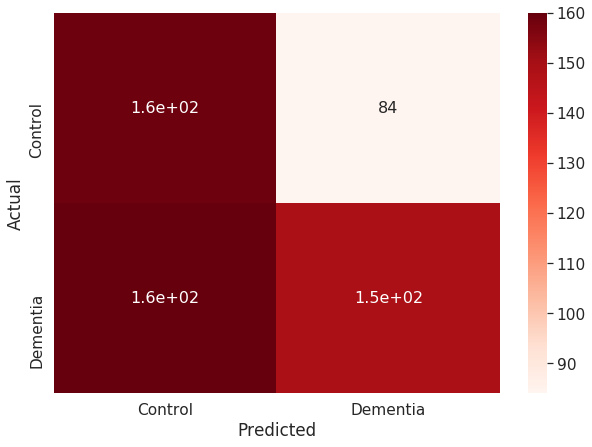

In [206]:
y_true = meta_pitt.Group
y_pred = meta_pitt.predict_group
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True, annot_kws={"size": 16})# font size

In [207]:
df_cm

Predicted,Control,Dementia
Actual,,
Control,159,84
Dementia,160,149


In [208]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

     Control       0.50      0.65      0.57       243
    Dementia       0.64      0.48      0.55       309

    accuracy                           0.56       552
   macro avg       0.57      0.57      0.56       552
weighted avg       0.58      0.56      0.56       552



/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 5 rows containing missing values.


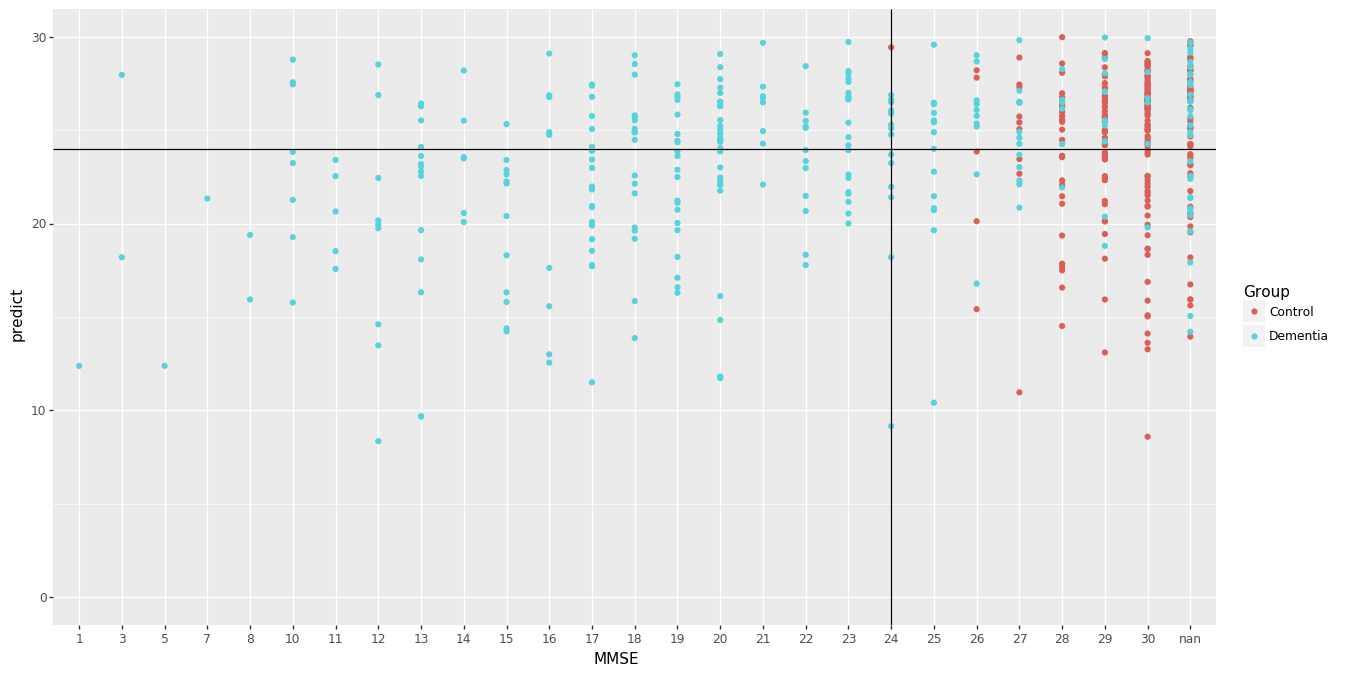

<ggplot: (8780852908913)>

In [209]:
ggplot(meta_pitt) + \
geom_point(aes(x = 'MMSE', y = 'predict', colour = 'Group')) + \
geom_hline(aes(yintercept = 24, lty = 2)) + \
geom_vline(aes(xintercept = 20, lty = 2)) + \
scale_y_continuous(limits = [0,30]) + \
theme(figure_size = (15, 8))